In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
from skimage.feature.texture import graycomatrix, graycoprops
from skimage.measure import regionprops, label
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

In [3]:
BASE_DIR            = "/content/gdrive/MyDrive"
TRAIN_IMAGES_PATH   = os.path.join(BASE_DIR, "train")
TEST_IMAGES_PATH    = os.path.join(BASE_DIR, "test")
TRAIN_METADATA_PATH = os.path.join(BASE_DIR, "ISIC_2020_Train_Metadata.csv")
TEST_METADATA_PATH  = os.path.join(BASE_DIR, "ISIC_2020_Test_Metadata.csv")

In [4]:
train_files = os.listdir(TRAIN_IMAGES_PATH)
test_files  = os.listdir(TEST_IMAGES_PATH)

print("Train total number of images:", len(train_files))
print("Test total number of images: ", len(test_files))

Train total number of images: 788
Test total number of images:  673


Read Metadata.csv files

In [5]:
train_metadata = pd.read_csv(TRAIN_METADATA_PATH)
test_metadata  = pd.read_csv(TEST_METADATA_PATH)

print("Train Metadata shape:", train_metadata.shape)
print("Test Metadata shape: ", test_metadata.shape)

Train Metadata shape: (1000, 9)
Test Metadata shape:  (1000, 5)


Adding .jpg to the image_name column

In [6]:
train_metadata['image_name_with_ext'] = train_metadata['image_name'].astype(str) + ".jpg"
test_metadata ['image_name_with_ext'] = test_metadata ['image'].astype(str) + ".jpg"

Adding the images in a set

In [7]:
train_image_files = set(os.listdir(TRAIN_IMAGES_PATH))
test_image_files  = set(os.listdir(TEST_IMAGES_PATH))

Filter the set

In [8]:
filtered_train = train_metadata[train_metadata['image_name_with_ext'].isin(train_image_files)].copy()
print("Train size filtered by file:", len(filtered_train))

Train size filtered by file: 788


Ensure that each class have at least two samples

In [9]:
class_counts   = filtered_train['diagnosis'].value_counts()
valid_classes  = class_counts[class_counts > 1].index
filtered_train = filtered_train[filtered_train['diagnosis'].isin(valid_classes)].copy()
print("Train size after removing classes with few samples:", len(filtered_train))

Train size after removing classes with few samples: 787


Map the label to integer

In [10]:
label_mapping = {label: idx for idx, label in enumerate(filtered_train['diagnosis'].unique())}
filtered_train['label'] = filtered_train['diagnosis'].map(label_mapping)

if 'diagnosis' in test_metadata.columns:
    test_metadata['label'] = test_metadata['diagnosis'].map(label_mapping)
else:
    test_metadata['label'] = pd.NA

Split train and test data


In [11]:
train_df, val_df = train_test_split(
    filtered_train,
    test_size=0.20,
    stratify=filtered_train['label'],
    random_state=42
)

print("Training set size:   ", len(train_df))
print("Validation set size:", len(val_df))

Training set size:    629
Validation set size: 158


Plot the Class Distribution

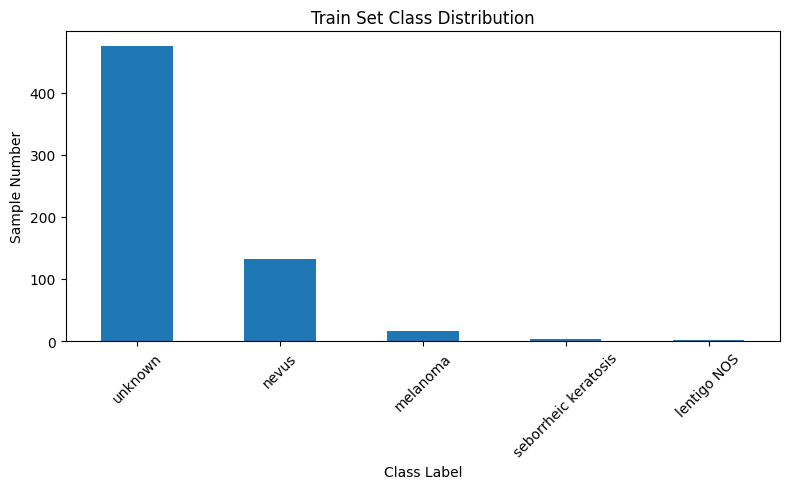

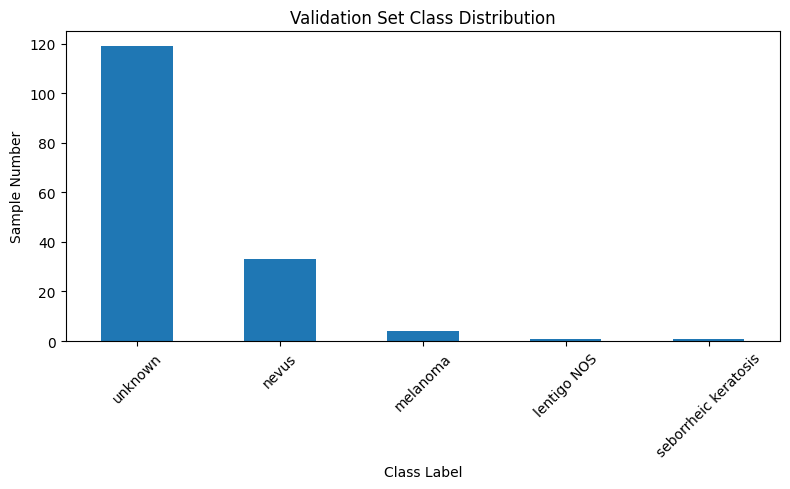

In [12]:
import matplotlib.pyplot as plt

def plot_class_distribution(df, label_col='diagnosis', title='Class Distribution'):
    class_counts = df[label_col].value_counts()

    plt.figure(figsize=(8, 5))
    class_counts.plot(kind='bar')
    plt.xlabel('Class Label')
    plt.ylabel('Sample Number')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_class_distribution(train_df, label_col='diagnosis', title='Train Set Class Distribution')
plot_class_distribution(val_df,   label_col='diagnosis', title='Validation Set Class Distribution')

Visualize the samples

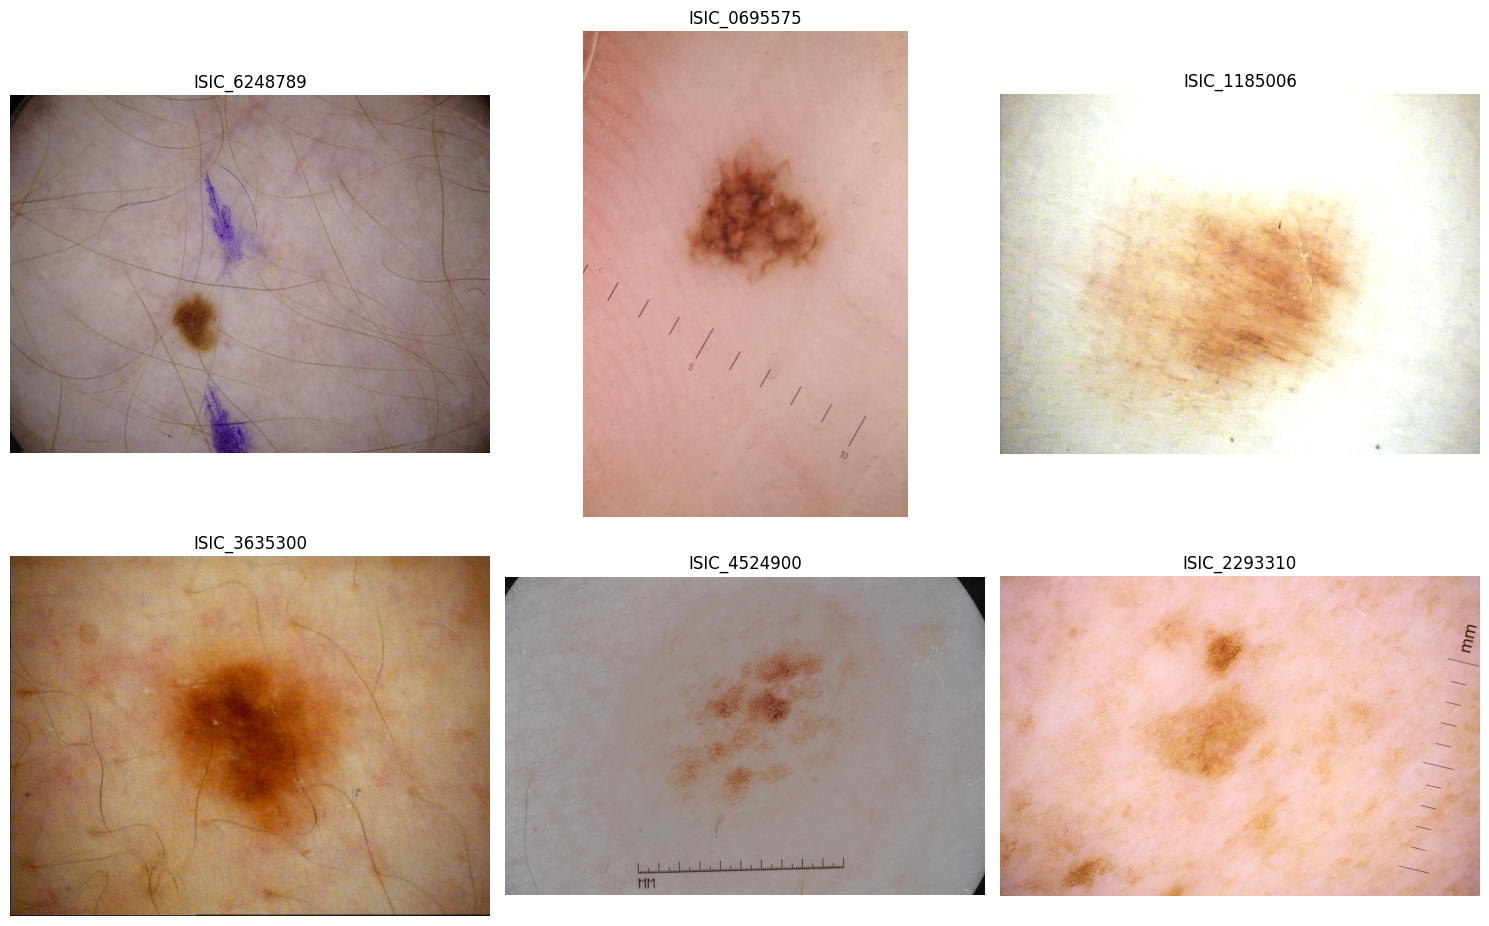

In [13]:
def visualize_samples(image_dir, metadata_df, num_samples=6):
    if metadata_df.empty:
        print("\nVisualize: metadata is empty, no examples to show.")
        return
    sample_images = metadata_df.sample(num_samples, random_state=42)
    plt.figure(figsize=(15, 10))
    for idx, (_, row) in enumerate(sample_images.iterrows()):
        img_path = os.path.join(image_dir, row['image_name_with_ext'])
        img      = cv2.imread(img_path)
        img      = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2, 3, idx + 1)
        plt.imshow(img)
        base_name = row['image_name_with_ext'].rsplit('.', 1)[0]
        plt.title(base_name)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

visualize_samples(TRAIN_IMAGES_PATH, filtered_train)

PyTorch Dataset Class

In [14]:
class ISICDataset(Dataset):
    def __init__(self, metadata_df, image_dir, transform=None):
        self.metadata  = metadata_df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row      = self.metadata.iloc[idx]
        img_path = os.path.join(self.image_dir, row['image_name_with_ext'])
        image    = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image not found at {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = int(row['label']) if not pd.isna(row['label']) else -1

        if self.transform:
            image = self.transform(image)
        return image, label

Data Transforms

In [16]:
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

DataLoaders

In [17]:
if not train_df.empty:
    train_dataset = ISICDataset(train_df, TRAIN_IMAGES_PATH, transform=data_transforms)
    val_dataset   = ISICDataset(val_df,   TRAIN_IMAGES_PATH, transform=data_transforms)

    train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )
    print("\nTrain/Val data loaders were successfully prepared.")
    images, labels = next(iter(train_loader))
    print("Example batch (image) size:", images.size())
    print("Example batch (label) size:", labels.size())
else:
    print("\nThere is not enough data to create a data loader.")

#DataLoader for Test
if 'label' in test_metadata.columns and test_metadata['label'].notna().any():
    filtered_test = test_metadata[test_metadata['image_name_with_ext'].isin(test_image_files)].copy()
    filtered_test['label'] = filtered_test['diagnosis'].map(label_mapping).fillna(-1).astype(int)
    test_dataset = ISICDataset(filtered_test, TEST_IMAGES_PATH, transform=data_transforms)
    test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
    print("Test data loader (labeled) is ready.")
else:
    class TestOnlyDataset(Dataset):
        def __init__(self, image_dir, image_files, transform=None):
            self.image_dir  = image_dir
            self.image_list = sorted(list(image_files))
            self.transform  = transform

        def __len__(self):
            return len(self.image_list)

        def __getitem__(self, idx):
            img_name = self.image_list[idx]
            img_path = os.path.join(self.image_dir, img_name)
            image    = cv2.imread(img_path)
            if image is None:
                raise FileNotFoundError(f"Image not found at {img_path}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            if self.transform:
                image = self.transform(image)
            return image, img_name

    test_dataset = TestOnlyDataset(TEST_IMAGES_PATH, test_image_files, transform=data_transforms)
    test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
    print("Test data loader (unlabeled) is ready.")


Train/Val data loaders were successfully prepared.


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Example batch (image) size: torch.Size([32, 3, 224, 224])
Example batch (label) size: torch.Size([32])
Test data loader (unlabeled) is ready.


Balancing Data

In [18]:
num_classes  = len(label_mapping)
total_wanted = 1000

base_per_class = total_wanted // num_classes
remainder      = total_wanted - base_per_class * num_classes

targets_per_class = {cls: base_per_class for cls in range(num_classes)}
for i, cls in enumerate(label_mapping.values()):
    if i < remainder:
        targets_per_class[i] += 1

print("Goal numbers (for each class):", targets_per_class, "\n")

rng = np.random.default_rng(42)
y_all = filtered_train['label'].values
idx_by_class = [np.where(y_all == c)[0] for c in range(num_classes)]

balanced_indices = []
for cls in range(num_classes):
    idx_cls   = idx_by_class[cls]
    n_target  = targets_per_class[cls]
    if n_target <= len(idx_cls):
        chosen = rng.choice(idx_cls, size=n_target, replace=False)
    else:
        extra  = rng.choice(idx_cls, size=(n_target - len(idx_cls)), replace=True)
        chosen = np.concatenate([idx_cls, extra])
    balanced_indices.append(chosen)

balanced_indices = np.concatenate(balanced_indices)
balanced_indices = rng.permutation(balanced_indices)

balanced_df = filtered_train.iloc[balanced_indices].reset_index(drop=True)
assert len(balanced_df) == total_wanted

print("Total samples after balancing:", len(balanced_df))
print("Class distribution after balancing:\n", balanced_df['diagnosis'].value_counts(), "\n")

Goal numbers (for each class): {0: 200, 1: 200, 2: 200, 3: 200, 4: 200} 

Total samples after balancing: 1000
Class distribution after balancing:
 diagnosis
nevus                   200
unknown                 200
melanoma                200
seborrheic keratosis    200
lentigo NOS             200
Name: count, dtype: int64 



Split Balanced Data

In [19]:
train_balanced_df, val_balanced_df = train_test_split(
    balanced_df,
    test_size=0.20,
    stratify=balanced_df['label'],
    random_state=42
)

# Handcrafted Methods

In [20]:
def extract_first_order_stats(gray_image):
    pixels = gray_image.flatten().astype(np.float64)
    mean_val = pixels.mean()
    std_val  = pixels.std()
    skew_val = stats.skew(pixels)
    kurt_val = stats.kurtosis(pixels)

    hist, _ = np.histogram(pixels, bins=256, range=(0, 255), density=True)
    hist = hist + 1e-8
    entropy_val = -np.sum(hist * np.log2(hist))

    return [mean_val, std_val, skew_val, kurt_val, entropy_val]

In [21]:
from skimage.measure import regionprops, label

def extract_handcrafted_features(image_bgr):
    blurred = cv2.GaussianBlur(image_bgr, (5, 5), 0)
    blurred = cv2.medianBlur(blurred, 5)

    gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel, iterations=2)

    label_img = label(closed)
    props = regionprops(label_img)
    if len(props) > 0:
        largest_region = max(props, key=lambda x: x.area)
        mask = (label_img == largest_region.label).astype(np.uint8)
    else:
        mask = np.zeros_like(gray)

    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    masked_pixels = image_rgb[mask == 1]
    if masked_pixels.size == 0:
        mean_color = np.zeros(3)
        std_color = np.zeros(3)
    else:
        mean_color = masked_pixels.mean(axis=0)
        std_color = masked_pixels.std(axis=0)

    area, perimeter = 0, 0
    hu_moments = np.zeros(7)
    if len(props) > 0:
        p = largest_region
        area = p.area
        perimeter = p.perimeter
        moments = cv2.moments(mask.astype(np.uint8))
        hu_moments = cv2.HuMoments(moments).flatten()

    gray_for_glcm = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    distances = [1]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = graycomatrix(
        gray_for_glcm,
        distances=distances,
        angles=angles,
        levels=256,
        symmetric=True,
        normed=True
    )
    contrast = graycoprops(glcm, 'contrast').mean()
    homogeneity = graycoprops(glcm, 'homogeneity').mean()

    first_order_stats = extract_first_order_stats(gray_for_glcm)

    feats = np.hstack([
        mean_color,
        std_color,
        [area, perimeter],
        hu_moments,
        [contrast, homogeneity],
        first_order_stats
    ])

    return feats

In [ ]:
from scipy import stats

X_handcrafted_train = []
y_train_labels = []

for idx, row in tqdm(train_balanced_df.iterrows(),
                      total=len(train_balanced_df),
                      desc="Extract features for balanced train"):
    img_name = row['image_name_with_ext']
    img_path = os.path.join(TRAIN_IMAGES_PATH, img_name)
    image_bgr = cv2.imread(img_path)
    if image_bgr is None:
        feat_dim = extract_handcrafted_features(np.zeros((5,5,3))).shape[0]
        X_handcrafted_train.append(np.zeros(feat_dim))
        y_train_labels.append(row['label'])
        continue

    feats = extract_handcrafted_features(image_bgr)
    X_handcrafted_train.append(feats)
    y_train_labels.append(row['label'])

X_handcrafted_train = np.array(X_handcrafted_train)
y_train_labels = np.array(y_train_labels)


X_handcrafted_val = []
y_val_labels = []

for idx, row in tqdm(val_balanced_df.iterrows(),
                      total=len(val_balanced_df),
                      desc="Extract features for balanced val"):
    img_name = row['image_name_with_ext']
    img_path = os.path.join(TRAIN_IMAGES_PATH, img_name)
    image_bgr = cv2.imread(img_path)
    if image_bgr is None:
        feat_dim = extract_handcrafted_features(np.zeros((5,5,3))).shape[0]
        X_handcrafted_val.append(np.zeros(feat_dim))
        y_val_labels.append(row['label'])
        continue

    feats = extract_handcrafted_features(image_bgr)
    X_handcrafted_val.append(feats)
    y_val_labels.append(row['label'])

X_handcrafted_val = np.array(X_handcrafted_val)
y_val_labels = np.array(y_val_labels)

scaler = StandardScaler().fit(X_handcrafted_train)
X_train_scaled = scaler.transform(X_handcrafted_train)
X_val_scaled = scaler.transform(X_handcrafted_val)

svm_clf = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    class_weight='balanced',
    random_state=42
)
svm_clf.fit(X_train_scaled, y_train_labels)

y_pred_val = svm_clf.predict(X_val_scaled)
print("\nBalanced Traditional Handcrafted + SVM Validation Results")
print("Accuracy:", accuracy_score(y_val_labels, y_pred_val))
print("\nClassification Report:")
print(classification_report(y_val_labels, y_pred_val, target_names=list(label_mapping.keys())))

Extract features for balanced val: 100%|██████████| 200/200 [07:23<00:00,  2.22s/it]


Balanced Traditional Handcrafted + SVM Validation Results
Accuracy: 0.895

Classification Report:
                      precision    recall  f1-score   support

               nevus       0.92      0.82      0.87        40
             unknown       0.90      0.68      0.77        40
            melanoma       0.85      0.97      0.91        40
         lentigo NOS       0.95      1.00      0.98        40
seborrheic keratosis       0.87      1.00      0.93        40

            accuracy                           0.90       200
           macro avg       0.90      0.89      0.89       200
        weighted avg       0.90      0.90      0.89       200



In [26]:
from scipy import stats
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report
from sklearn.model_selection import StratifiedKFold

all_feats = []
all_labels = []

for idx, row in tqdm(balanced_df.iterrows(),
                      total=len(balanced_df),
                      desc="Extract features for full balanced set"):
    img_name = row['image_name_with_ext']
    img_path = os.path.join(TRAIN_IMAGES_PATH, img_name)
    image_bgr = cv2.imread(img_path)
    if image_bgr is None:
        feat_dim = extract_handcrafted_features(np.zeros((5,5,3))).shape[0]
        all_feats.append(np.zeros(feat_dim))
        all_labels.append(row['label'])
        continue

    feats = extract_handcrafted_features(image_bgr)
    all_feats.append(feats)
    all_labels.append(row['label'])

X_all = np.array(all_feats)
y_all = np.array(all_labels)

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

accuracy_list  = []
precision_list = []
recall_list    = []
f1_list        = []

for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_all, y_all), start=1):
    X_train_fold = X_all[train_idx]
    y_train_fold = y_all[train_idx]
    X_val_fold   = X_all[val_idx]
    y_val_fold   = y_all[val_idx]

    scaler_fold = StandardScaler().fit(X_train_fold)
    X_train_scaled_fold = scaler_fold.transform(X_train_fold)
    X_val_scaled_fold   = scaler_fold.transform(X_val_fold)

    svm_fold = SVC(kernel='rbf',
                   C=1.0,
                   gamma='scale',
                   class_weight='balanced',
                   random_state=42)
    svm_fold.fit(X_train_scaled_fold, y_train_fold)

    y_pred_fold = svm_fold.predict(X_val_scaled_fold)
    acc  = accuracy_score(y_val_fold, y_pred_fold)
    prec = precision_score(y_val_fold, y_pred_fold, average='weighted', zero_division=0)
    rec  = recall_score(y_val_fold, y_pred_fold, average='weighted', zero_division=0)
    f1   = f1_score(y_val_fold, y_pred_fold, average='weighted', zero_division=0)

    accuracy_list.append(acc)
    precision_list.append(prec)
    recall_list.append(rec)
    f1_list.append(f1)

    print(f"Fold {fold_idx} → Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

Extract features for full balanced set: 100%|██████████| 1000/1000 [33:13<00:00,  1.99s/it]

Fold 1 → Accuracy: 0.9200, Precision: 0.9258, Recall: 0.9200, F1: 0.9184
Fold 2 → Accuracy: 0.8300, Precision: 0.8315, Recall: 0.8300, F1: 0.8223
Fold 3 → Accuracy: 0.9100, Precision: 0.9131, Recall: 0.9100, F1: 0.9043
Fold 4 → Accuracy: 0.8750, Precision: 0.8786, Recall: 0.8750, F1: 0.8700
Fold 5 → Accuracy: 0.9150, Precision: 0.9156, Recall: 0.9150, F1: 0.9121


In [27]:
acc_mean, acc_std   = np.mean(accuracy_list),  np.std(accuracy_list)
prec_mean, prec_std = np.mean(precision_list), np.std(precision_list)
rec_mean, rec_std   = np.mean(recall_list),    np.std(recall_list)
f1_mean, f1_std     = np.mean(f1_list),        np.std(f1_list)

print("\n5-Fold Cross-Validation Results")
print(f"Accuracy  : {acc_mean:.4f} ± {acc_std:.4f}")
print(f"Precision : {prec_mean:.4f} ± {prec_std:.4f}")
print(f"Recall    : {rec_mean:.4f} ± {rec_std:.4f}")
print(f"F1‐Score  : {f1_mean:.4f} ± {f1_std:.4f}")


5-Fold Cross-Validation Results
Accuracy  : 0.8900 ± 0.0339
Precision : 0.8929 ± 0.0346
Recall    : 0.8900 ± 0.0339
F1‐Score  : 0.8854 ± 0.0357
